# MODELLING AND EVALUATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel,delayed,dump

from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
##custom functions from cust_funcs.py
from cust_funcs import linear_impute_transform,linear_imputer,prepare_dataset,prepare_training_features

In [9]:
df=pd.read_csv('Data/training.csv')
X,weights,y=prepare_dataset(df)

## Building a Model for Boosted Extremely Randomized Tree (BXT)

- This is a hybrid tree model which theoretically should work well in cases on unabalanced and overlapping datasets such as ours
- Traditional boosted methods such as **AdaBoost** uses an ensemble of weak learners to produce a strong master learner.
- This is achieved through a decision rule for the master learner that is a weighted combination of the base learners outcomes     and the weights are usually a function of the weak learners accuracy
 $$
 \begin{align}
 M_J=\sum_j \alpha_jh_j(x)
 \end{align}
 $$
- This usually leads to high varaince and low bias, ie it increases the risk of overfitting especially with unbalaced datasets
- A Random Forest algorithm takes care of this problem through bagging after generating random trees which are split at nodes that redices entropy from a set of randomly selected features
- An extremely randomized tree (ET) is one of the newer incarnations of the random forest method which introduce further randomization in the tree construction process.
-  While random forests attempt to create diversified trees by usinga bootstrap samples, ETs work like random forests but take the randomization one step further by choosing a random split point at each node rather than searching for the best split. This ensures the creation of strongly decorrelated and diverse trees.
- ETs have a computational benefit because they do not search for the best split at each node. The algorithm we propose here combines a bagged ensemble of ETs with a boosting framework. This nested structure can prevent overfitting, which is a major drawback of AdaBoost.

In [5]:
trees=ExtraTreesClassifier(n_estimators=50,max_features=None)
BXT=AdaBoostClassifier(estimator=trees,n_estimators=50)

## Split, Train and Test

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [14]:
BXT.fit(X_train,y_train)

AdaBoostClassifier(estimator=ExtraTreesClassifier(max_features=None,
                                                  n_estimators=50))

In [15]:
predictions=BXT.predict(X_test)

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     49555
           1       0.78      0.71      0.75     25445

    accuracy                           0.84     75000
   macro avg       0.82      0.81      0.81     75000
weighted avg       0.83      0.84      0.83     75000



The above result is statistically significant

## Evaluation Metric: Approximate Median Significance(AMS)

- AMS stands for Approximate Median Significance, which is a metric used to evaluate the performance of classification models in the Higgs ML Challenge
- AMS is based on the expected significance of the signal process, which depends on the number of signal and background events passing a certain threshold
-  AMS was chosen as the metric because it reflects the goal of finding a region in the feature space that maximizes the chance of discovering the Higgs boson
- The equation for AMS is given by,
$$\begin{align}
\text{AMS} = \sqrt{2\left((s+b+b_r)\ln\left(1+\frac{s}{b+b_r}\right)-s\right)}
\end{align}
$$
- Here $s$ is the weighted number of true positive signal events, $b$ is the weighted number of false positive background events, and $b_r$ is a regularization term that accounts for the uncertainty in the background estimation. The regularization term is fixed at 10. 
- Weights are used to adjust the values of s and b according to the expected number of events. Each event in the training and test data has a weight associated with it, which reflects the relative frequency of that event type. 

## HyperParameter Tuning and Cross-Validation

Designing a custom cross validation and hyperparameter tuning fucntion becasue `GridSearchCV` cannot benchmark paramters of the ETs.

In [26]:
def ams_curve_tuning(X,y,lr,n,rand_state):
    
        X_train,X_val,y_val,y_val=train_test_split(X,y,test_size=0.3,stratify=y,random_state=rand_state)
        X_train=linear_impute_transform(X_train,linear_imputer(X_train))
        X_val=linear_impute_transform(X_test,linear_imputer(X_train))  ##Avoids data leakage
        im=SimpleImputer(missing_values=-999,strategy='median')
        X_train=im.fit_transform(X_train)
        X_val=im.transform(X_val)
        
        
        tree=ExtraTreesClassifier(n_estimators=n,max_features=None,n_jobs=1,random_state=rand_state,min_samples_leaf=2)
        BXT=AdaBoostClassifier(estimator=tree,n_estimators=50,learning_rate=lr)
        BXT.fit(X_train,y_train)

        prediction_proba=BXT.predict_proba(X_val)[:,1]
        test_weights=weights.iloc[y_test.index]
        
        A=[]
        for t in np.arange(0.05,1,0.01):
            predictions=np.where(prediction_proba>t,1,0)
            s=np.dot(test_weights/0.3,((y_val==1)&(predictions==1)).astype('int64'))
                                                                                        ## Calculcating AMS for a threshold t
            b=np.dot(test_weights/0.3,((y_val==0)&(predictions==1)).astype('int64'))

            A.append(np.sqrt(2*(((s+b+10)*np.log(1+(s/(b+10))))-s)))
        return max(A)

The `ams_curve_tuning` function tests hyperparamters against AMS curve as a function of thresholds

In [5]:
parameters={
    'learning_rate':[0.05,0.1,1,1.5,2],
    'ET_estimators':[150,200,250,300,350]
}

The search is also **parallelised** to improve performance

In [27]:
random_states=np.random.randint(10,100,8)
AMS_vals=[];N=[];LR=[]
for lr in parameters['learning_rate']:
    for n in parameters['ET_estimators']:

        trial_vals=Parallel(n_jobs=4)(delayed(ams_curve_tuning)(X,y,lr,n,random_states[i]) for i in range(4))
        AMS_vals.append(np.mean(trial_vals));N.append(n);LR.append(lr) 
        
        print('Mean ams = {}, lr = {}, n = {}'.format(np.mean(trial_vals),lr,n))
        
LR=np.array(LR);AMS_vals=np.array(AMS_vals);N=np.array(N)        
print('BEST SCORES: ams = {}, lr = {}, n = {}'.format(max(AMS_vals),
                                                      LR[AMS_vals==max(AMS_vals)][0],N[AMS_vals==max(AMS_vals)][0]))

Mean ams = 3.430048179580882, lr = 0.05, n = 150
Mean ams = 3.4268175276856137, lr = 0.05, n = 200
Mean ams = 3.4288371524675614, lr = 0.05, n = 250
Mean ams = 3.431465328109843, lr = 0.05, n = 300
Mean ams = 3.4375704905866757, lr = 0.05, n = 350
Mean ams = 3.412345181032586, lr = 0.1, n = 150
Mean ams = 3.4224941258046684, lr = 0.1, n = 200
Mean ams = 3.443619080688054, lr = 0.1, n = 250
Mean ams = 3.424061702258539, lr = 0.1, n = 300
Mean ams = 3.43964584043575, lr = 0.1, n = 350
Mean ams = 3.436704520172342, lr = 1, n = 150
Mean ams = 3.4593962429179594, lr = 1, n = 200
Mean ams = 3.4720190628402423, lr = 1, n = 250
Mean ams = 3.4722441550818135, lr = 1, n = 300
Mean ams = 3.4721250475665024, lr = 1, n = 350
Mean ams = 3.47378711951285, lr = 1.5, n = 150
Mean ams = 3.4911527224181027, lr = 1.5, n = 200
Mean ams = 3.50650489424366, lr = 1.5, n = 250
Mean ams = 3.500215130240974, lr = 1.5, n = 300
Mean ams = 3.485973096831537, lr = 1.5, n = 350
Mean ams = 3.4676705843486095, lr = 2, 

## Fitting and Prediction

In [14]:
trees=ExtraTreesClassifier(n_estimators=250,max_features=None,min_samples_leaf=2,n_jobs=-1)
BXT=AdaBoostClassifier(estimator=trees,n_estimators=50,learning_rate=1.5)

In [12]:
X_test,weights,y_test=prepare_dataset(pd.read_csv('Data/testing.csv',index_col=0))

X_train,_,y_train=prepare_dataset(pd.read_csv('Data/training.csv'))

X_test=prepare_training_features(X_test,X_dep=X_train)

In [15]:
BXT.fit(X_train,y_train)

AdaBoostClassifier(estimator=ExtraTreesClassifier(max_features=None,
                                                  min_samples_leaf=2,
                                                  n_estimators=250, n_jobs=-1),
                   learning_rate=1.5)

In [71]:
def ams_curve(prediction_proba,y_test,test_weights,test_ratio):
    A=[]
    for t in np.arange(0.05,1,0.01):
        predictions=np.where(prediction_proba>t,1,0)
        s=np.dot(test_weights,((y_test==1)&(predictions==1)).astype('int64'))
                                                                                
        b=np.dot(test_weights,((y_test==0)&(predictions==1)).astype('int64'))

        A.append(np.sqrt(2*(((s+b+10)*np.log(1+(s/(b+10))))-s)))
    A=np.array(A)
    Dat=np.stack((np.arange(0.05,1,0.01),A),axis=1)
    plt.plot(Dat[:,0],Dat[:,1])
    plt.title('AMS vs Decision Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('AMS')
    return Dat,max(A)

In [31]:
prediction_proba=BXT.predict_proba(X_test)[:,1]

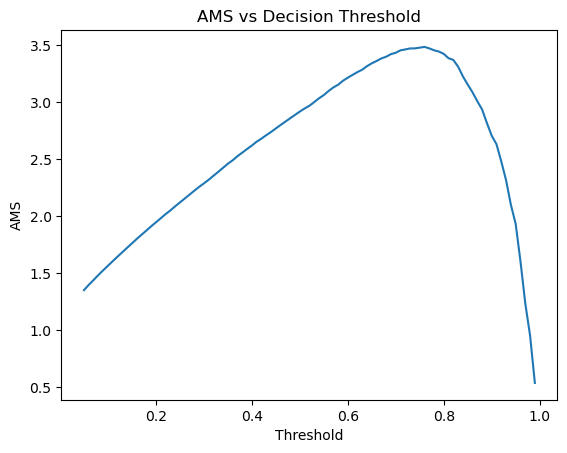

In [72]:
ams_dat,max_ams=ams_curve(prediction_proba,y_test,weights,test_ratio=1)

In [74]:
np.savetxt('Data/BXT_curve.csv',ams_dat)

In [73]:
print('Final AMS = {}'.format(max_ams))

Final AMS = 3.4860301191263914
